In [12]:
import numpy
import numpy as np
import random
import glob
import os
import cv2
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim


from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)



In [13]:
## Data augmentation 
# This segment will take the original images (2XX images with various dimensions) and augment the data,
# reshape the images in 32*32
# and sort it between training images and testing images
# Original images in a 'Original_Data' directory
# Resulting images in a 'Augmented_Data' directory

Training_Image_Path = '../Augmented_Data/Training/'
Test_Image_Path = '../Augmented_Data/Test/'
Source_Image_Path = "../Original_Data/"
classes = ["Rock/", "Paper/", "Scissors/"]

# percentage_split of images are testing images
percentage_split = 0.2

data_not_yet_augmented = 0
data_not_yet_splitted = 0

# Data augmentation and reshaping of the images
# All the images are placed at the root of the directory "Augmented_Data" in subfolders "Rock"...

if data_not_yet_augmented :
    for classe in classes:
        images = glob.glob(Source_Image_Path + classe + "*.jpg")
        
        for img in images:
            name = img.split("/")[-1]
            name_wo_ext = name[:-4]
            img_array = imageio.imread(img)
            [w,h,_] = img_array.shape
        
            img_flipped = cv2.flip(img_array,1)
            img_cropped_1 = img_array[5:w-5, 5:h-5,:]
            img_cropped_2 = img_array[20:w-20, 20:h-20, :]
            img_cropped_3 = img_array[40:w-40, 40:h-40, :]
            
            img_cropped_1_flipped = cv2.flip(img_cropped_1, 1)
            img_cropped_2_flipped = cv2.flip(img_cropped_2, 1)
            img_cropped_3_flipped = cv2.flip(img_cropped_3, 1)
        
        
        
            img_array = cv2.resize(img_array, (32, 32))
            img_flipped = cv2.resize(img_flipped, (32, 32)) 
            img_cropped_1 = cv2.resize(img_cropped_1, (32, 32)) 
            img_cropped_2 = cv2.resize(img_cropped_2, (32, 32)) 
            img_cropped_3 = cv2.resize(img_cropped_3, (32, 32)) 
            img_cropped_1_flipped = cv2.resize(img_cropped_1_flipped, (32, 32))
            img_cropped_2_flipped = cv2.resize(img_cropped_2_flipped, (32, 32)) 
            img_cropped_3_flipped = cv2.resize(img_cropped_3_flipped, (32, 32))
        
        
        
            imageio.imwrite("../Augmented_Data/"+ classe + name, img_array)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_flipped.jpg", img_flipped)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_1.jpg", img_cropped_1)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_2.jpg", img_cropped_2)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_3.jpg", img_cropped_3)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_1_flipped.jpg", img_cropped_1_flipped)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_2_flipped.jpg", img_cropped_2_flipped)
            imageio.imwrite("../Augmented_Data/" + classe + name_wo_ext + "_cropped_3_flipped.jpg", img_cropped_3_flipped)
        
        print("The images of the class " + classe.split("/")[0] + " have been augmented")
    
    
print("Data augmentation has been done (8 times more data)")


# Splitting the data between Training and Test
if data_not_yet_splitted:
    for classe in classes:
        images = glob.glob("../Augmented_Data/" + classe + "*.jpg")
    
        for img in images:
            name = img.split('/')[-1]
            rd = random.random()
            if rd <= percentage_split:
                destination_path = Test_Image_Path + classe
            else:
                destination_path = Training_Image_Path + classe
        
            os.rename(img, destination_path + name)
        print("The images of the class " + classe.split('/')[0] + " have been split amongst testing and training images")
    

        
print("Images have been splitted")




The images of the class Rock have been augmented
The images of the class Paper have been augmented
The images of the class Scissors have been augmented
Data augmentation has been done (8 times more data)
The images of the class Rock have been split amongst testing and training images
The images of the class Paper have been split amongst testing and training images
The images of the class Scissors have been split amongst testing and training images
Images have been splitted


In [14]:
train = ImageFolder(Training_Image_Path,transform=transforms.Compose([transforms.Grayscale(),
    transforms.ToTensor()]))

test = ImageFolder(Test_Image_Path,transform=transforms.Compose([transforms.Grayscale(),
    transforms.ToTensor()]))

print (train)
print (test)
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=20)
train_loader = dataloader.DataLoader(train, **dataloader_args)

dataloader_args = dict(shuffle=True, batch_size=20)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Dataset ImageFolder
    Number of datapoints: 1135
    Root Location: ../Augmented_Data/Training/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 297
    Root Location: ../Augmented_Data/Test/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [15]:
# Model 
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = x.view((-1, 1024))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)  
        
        

In [16]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
EPOCHS = 50
losses = []

# Eval
#evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
#evaluate_y = Variable(test_loader.dataset.test_labels)

dataiter = iter(train_loader)
evaluate_x , evaluate_y = dataiter.next()



train_size = len(train_loader.dataset)
batch_size = (train_size / 20) if (cuda) else  (train_size / 20)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')

    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))





    

 Train Epoch: 1/50 [1135/1135 (99%)]	Loss: 1.109705	 Test Accuracy: 50.0000%
 Train Epoch: 2/50 [1135/1135 (99%)]	Loss: 1.141925	 Test Accuracy: 70.0000%
 Train Epoch: 3/50 [1135/1135 (99%)]	Loss: 0.904934	 Test Accuracy: 65.0000%
 Train Epoch: 4/50 [1135/1135 (99%)]	Loss: 1.452307	 Test Accuracy: 75.0000%
 Train Epoch: 5/50 [1135/1135 (99%)]	Loss: 0.718984	 Test Accuracy: 80.0000%
 Train Epoch: 6/50 [1135/1135 (99%)]	Loss: 0.646356	 Test Accuracy: 70.0000%
 Train Epoch: 7/50 [1135/1135 (99%)]	Loss: 1.032954	 Test Accuracy: 75.0000%
 Train Epoch: 8/50 [1135/1135 (99%)]	Loss: 0.812207	 Test Accuracy: 90.0000%
 Train Epoch: 9/50 [1135/1135 (99%)]	Loss: 0.727865	 Test Accuracy: 75.0000%
 Train Epoch: 10/50 [1135/1135 (99%)]	Loss: 0.632137	 Test Accuracy: 90.0000%
 Train Epoch: 11/50 [1135/1135 (99%)]	Loss: 0.730659	 Test Accuracy: 80.0000%
 Train Epoch: 12/50 [1135/1135 (99%)]	Loss: 0.520240	 Test Accuracy: 75.0000%
 Train Epoch: 13/50 [1135/1135 (99%)]	Loss: 0.567930	 Test Accuracy: 95.0

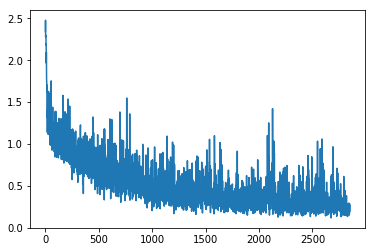

In [18]:
plt.plot(losses)

In [19]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy:', accuracy*100)

Accuracy: 95.0
